## Run Network
Script for using existing network to run on cohort data

In [1]:
import os
import numpy as np
from deepcell import model_zoo
import matplotlib.pyplot as plt
import xarray as xr
import math

In [2]:
# load data
data_dir = '/data/roshan/Segmentation1/'
cohort_xr = xr.load_dataarray(os.path.join(data_dir,'Segmentation1_138.nc'))

In [3]:
experiment_folder = "20190822_training_freeze_1"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'training_freeze_1_H3_NaK_256x256_stride_0.3_test_convolutional_61_rf_512_dense_128_conv_epoch1.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [3]:
experiment_folder = "20191112_lab_combined"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'lab_combined_train_nolamin_256x256_stride_0.3_convolutional_61_rf_512_dense_128_conv.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [4]:
run_pixel_model = model_zoo.bn_feature_net_skip_2D(
    n_skips=3,
    fgbg_model=None,
    n_dense_filters=512,
    n_conv_filters=128,
    n_features=3,
    norm_method='std',
    receptive_field=61,
    last_only=False,
    n_channels=1,    
    input_shape=tuple(cohort_xr.shape[1:]))

run_pixel_model.load_weights(weights_path)

W0121 23:36:30.589733 140139597600576 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
output_array = np.zeros((cohort_xr.shape[:3] + (3,)), dtype='float32')

In [6]:
# run through supplied points
batch_size = 2
size = cohort_xr.shape[0]
num_batch = math.floor(size / batch_size)    

In [7]:
for i in range(num_batch):
    print("start at {}".format(i * batch_size))
    print("end at {}".format((i + 1)*batch_size))
    output_array[(i * batch_size):((i + 1)*batch_size), :, :, :] = run_pixel_model.predict(cohort_xr.values[(i * batch_size):((i + 1)*batch_size), :, :, :])[-1]
if size % batch_size != 0:
    print("start at {}".format(num_batch * batch_size))
    print("end at {}".format(num_batch * batch_size + size % batch_size))
    output_array[(num_batch * batch_size):(num_batch * batch_size + size % batch_size), :, :, :] = run_pixel_model.predict(cohort_xr.values[(num_batch * batch_size):(num_batch * batch_size + size % batch_size), :, :, :])[-1]

start at 0
end at 2
start at 2
end at 4
start at 4
end at 6
start at 6
end at 8
start at 8
end at 10
start at 10
end at 12


In [8]:
output_array = output_array * 127
output_array = output_array.astype("int8")

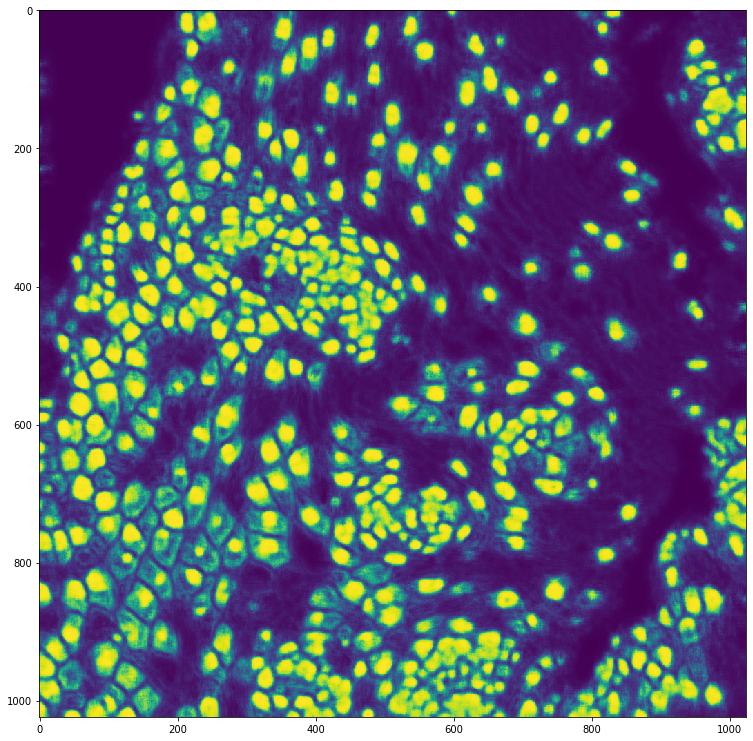

In [27]:
plt.figure(figsize = (13, 13))
plt.imshow(output_array[0, :, :, 1])

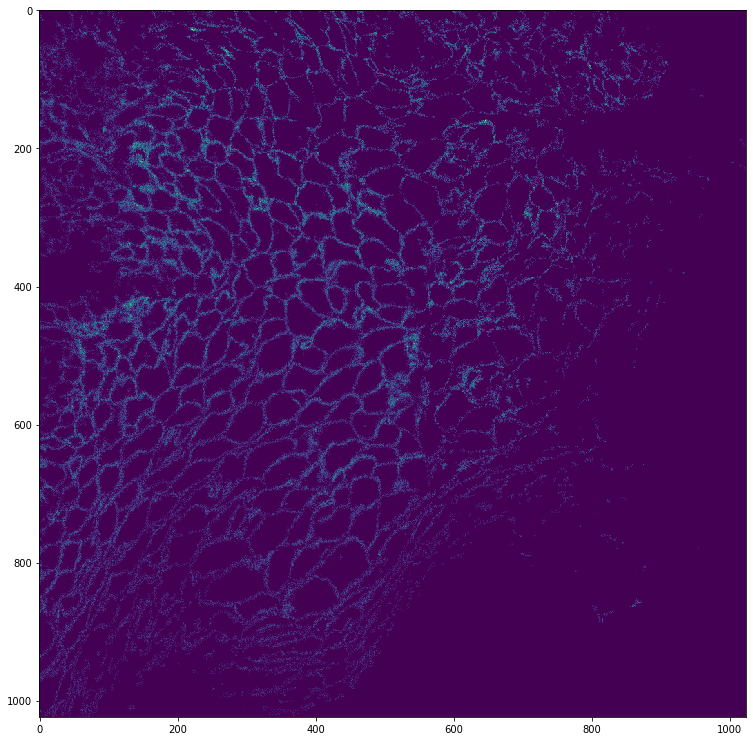

In [16]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[5, :, :, 1] * 2)

In [18]:
xr_output = xr.DataArray(output_array,
                         coords=[cohort_xr.coords['points'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), ['border', 'interior', 'bg']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output.to_netcdf(os.path.join(data_dir, "deepcell_output_138_pixel.nc"), format="NETCDF3_64BIT")

# Run watershed network

In [19]:
experiment_folder = "20191112_lab_combined"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'lab_combined_train_nolamin_256x256_stride_0.3_convolutional_watershed_61_rf_256_dense_64_conv_epoch2.h5'
watershed_weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [20]:
run_watershed_model = model_zoo.bn_feature_net_skip_2D(
     n_skips=3,
    fgbg_model=None,
    n_dense_filters=256,
    n_conv_filters=64,
    n_features=4,
    norm_method='std',
    receptive_field=61,
    last_only=False,
    n_channels=1,    
    input_shape=tuple(cohort_xr.shape[1:]))

run_watershed_model.load_weights(watershed_weights_path)

In [21]:
output_array_watershed = np.zeros((cohort_xr.shape[:3] + (4,)))

In [22]:
# run through supplied points
batch_size = 2
size = cohort_xr.shape[0]
num_batch = math.floor(size / batch_size)    

In [23]:
for i in range(num_batch):
    print("start at {}".format(i * batch_size))
    print("end at {}".format((i + 1)*batch_size))
    output_array_watershed[(i * batch_size):((i + 1)*batch_size), :, :, :] = run_watershed_model.predict(cohort_xr.values[(i * batch_size):((i + 1)*batch_size), :, :, :])[-1]
if size % batch_size != 0:
    print("start at {}".format(num_batch * batch_size))
    print("end at {}".format(num_batch * batch_size + size % batch_size))
    output_array_watershed[(num_batch * batch_size):(num_batch * batch_size + size % batch_size), :, :, :] = run_watershed_model.predict(cohort_xr.values[(num_batch * batch_size):(num_batch * batch_size + size % batch_size), :, :, :])[-1]

start at 0
end at 2
start at 2
end at 4
start at 4
end at 6
start at 6
end at 8
start at 8
end at 10
start at 10
end at 12


In [24]:
argmax_images = []
for j in range(output_array_watershed.shape[0]):
    argmax_images.append(np.argmax(output_array_watershed[j, ...], axis=-1))
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)
argmax_images = argmax_images.astype('int8')

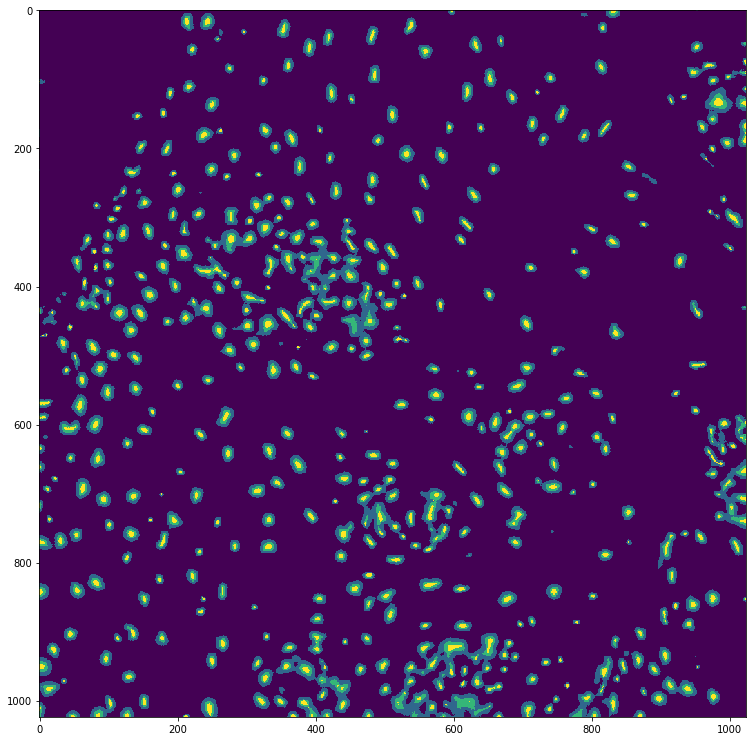

In [25]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :, 0])

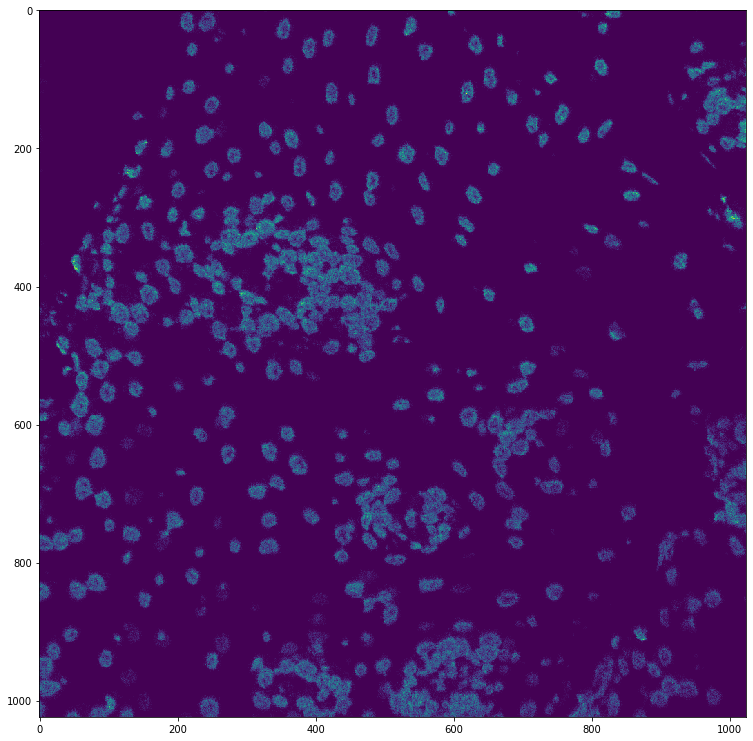

In [26]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr.values[0, :, :, 0])

In [28]:
xr_output_watershed = xr.DataArray(argmax_images,
                         coords=[cohort_xr.coords['points'], range(cohort_xr.shape[1]), range(cohort_xr.shape[2]), ['watershed_argmax']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output_watershed.to_netcdf(os.path.join(data_dir, "deepcell_output_138_watershed.nc"), format="NETCDF3_64BIT")